# CrossValidation

INPUT: parameter set, either:
  - a file with parameters
  - setting to generate a uniformly distributed set



fit 3 experiments using the parameters we have.

sanity check: plotting fit for each against the data it was trained on.

then: train part 2






In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

import models.ramp
import models.transient
import models.sustained

import experiments.ramp
import experiments.transient
import experiments.sustained

from model import Model
from utils.utils import read_config, DATA_PATH, RESULTS_PATH, generate_uniform_dist_param

all_models = [
  models.ramp,
  models.transient,
  models.sustained
]

all_experiments = [
  experiments.ramp,
  experiments.transient,
  experiments.sustained,
]

EXPERIMENT = 1
MODEL = 0

all = list(zip(all_models, all_experiments))

param_len = len(models.ramp.param_list)
for m in all_models: assert len(m.param_list) == param_len


/Users/polya/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/polya/workshop/research-project/experiments/sustained.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ex['y'] = ex.groupby('group')['frac_sub'].transform(lambda x: x / x.max())
/Users/polya/workshop/research-project/models/sustained.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['group', 'time'], as_index=False)


In [ ]:
import sympy
from IPython.display import display, Math
import sympy as sp
sympy.init_printing()

In [ ]:
equations = models.transient.model_eqs(models.transient.param_list, models.transient.nodes)['base_equations']
display(Math(r"\\\\".join([sp.latex(eq) for eq in equations])))

In [2]:


param_names = RESULTS_PATH / 'uniform.json'
#param_names = 'Sustained_v1_22-10-2025_23:23:31_L-BFGS-B.json'
default_parametrs = read_config(RESULTS_PATH / 'uniform.json', parameters=all_models[0].param_list)
#for k in default_parametrs.keys(): assert default_parametrs[k] == read_back[k]


Loaded 20 parameters from /Users/polya/workshop/research-project/results/uniform.json


In [ ]:
%%time
# Main course


y0 = [0.05] * 5
sim_steps = 200
m = models.ramp

#figs = []
results_single = {}
for i, me in list(enumerate(list(all)))[0:]:
  (model, experiment) = me
  df:pd.DataFrame = model.df
  groups = df['group'].unique()
  print('starting', model.__name__, experiment.__name__, 'groups:', groups)
  #fig, ax = plt.subplots(len(groups), 2, squeeze=False)
  t_max = max(df['time'])
  y_max = max(df['y'])

  lf = experiment.light_fn
  param_list = model.param_list
  states = model.nodes

  # control: train model on its base data - if this looks bad, maybe there's a bug in the model/light_fn.
  m = Model(
    name = f'control_{model.__name__}',
    parameters = param_list,
    states = model.nodes,
    model_definition = model.model_eqs,
    t_func = experiment.light_fn,
    t_dep = 'light'
    ,minimizer_method='Nelder-Mead'
    )
  res = m.fit(df, y0, parameters=param_names )
  #fig.suptitle(f"{model.__name__}: data vs simulation")
  #ax[0,0].set_title("Data")
  #ax[0,1].set_title("Simulation")
  results_by_group = {}
  for gr_i, gr in enumerate(groups):
    dff = df[df['group'] == gr]
    #ax[gr_i,0].plot(dff['time'], dff['y'],label=gr)
    #ax[gr_i,0].set_ylim(0,y_max)
    #ax[gr_i,0].set_ylabel(gr)
    sim_t = np.linspace(1, max(dff['time']), sim_steps)
    sol = m.simulate(sim_t, y0, group=gr)
    #ax[gr_i,1].plot(sim_t, sol.y[-1], label='sol')
    #ax[gr_i,1].set_ylim(0,y_max)
    results_by_group[gr] = (dff, sol, sim_t)
  results_single[me] = {"name":model.__name__, "df":df, "groups":groups, "results_by_group":results_by_group }
  #figs.append(fig)
  m.save_results()


In [ ]:
figs = []
y0 = [0.05] * 5
sim_steps = 200
for res in results_single.values():
  groups = res['groups']
  fig, ax = plt.subplots(len(groups), 2, squeeze=False)
  fig.suptitle(f"{res['name']}")
  ax[0,0].set_title("Data")
  ax[0,1].set_title("Simulation")
  df = res['df']
  t_max = max(df['time'])
  y_max = max(df['y'])

  for gr_i, gr in enumerate(groups):
    sim_t = res['results_by_group'][gr][2] 
    dff = df[df['group'] == gr]
    ax[gr_i,0].plot(dff['time'], dff['y'],label=gr)
    ax[gr_i,0].set_ylim(0,y_max)
    ax[gr_i,0].set_ylabel(gr)
    #sol = m.simulate(sim_t, y0, group=gr)
    sol = res['results_by_group'][gr][1]
    ax[gr_i,1].plot(sim_t, sol.y[-1], label='sol')
    ax[gr_i,1].set_ylim(0,y_max)
  figs.append(fig)

figs

  
  

In [ ]:
figs = []
y0 = [0.05] * 5
sim_steps = 200
for res in results_single.values():
  groups = res['groups']
  fs = (6,8) if 'transient' in res['name'] else (6,6)
  fig, ax = plt.subplots(len(groups), squeeze=False, figsize=fs, tight_layout=True)
  fig.suptitle(f"{res['name']}")
  #ax[0,0].set_title("Data")
  #ax[0,1].set_title("Simulation")
  df = res['df']
  t_max = max(df['time'])
  y_max = max(df['y']) * 1.1

  for gr_i, gr in enumerate(groups):
    dff = df[df['group'] == gr]
    sim_t =res['results_by_group'][gr][2]
 
    ax[gr_i,0].plot(dff['time'], dff['y'],label=f'Data')
    ax[gr_i,0].set_ylim(0,y_max)
    ax[gr_i,0].set_ylabel(gr)
    #sol = m.simulate(sim_t, y0, group=gr)
    sol = res['results_by_group'][gr][1]
    ax[gr_i,0].plot(sim_t, sol.y[-1], label='Simulation')
    #ax[gr_i,0].set_ylim(0,y_max)
    ax[gr_i,0].legend()
  figs.append(fig)

figs

  
  

In [ ]:
#idx = 1
#names = [f'single_fit_{m}' for m in ['ramp', 'transient','sustained']]
#pts = f'/Users/polya/workshop/research_project_report/static/'
#for f,n in zip(figs,names):
#  f.savefig(f'{pts}{n}_{idx}.png')
  

In [ ]:
def light_func2(t, rest=None):
  # Smooth transitions to avoid solver issues
  delta_t = 0.2
  assert type(rest) == None or type(rest) == dict, f"rest is not what it should be: {rest}"
  if (10-delta_t) < t < (10+delta_t): 
    modifier = float(rest['group'])
    if modifier == 0: return 0
    log_modifier = np.log(modifier)
    return (log_modifier - log_modifier * (np.abs(10-t)/delta_t)) / np.log(1000) 
  else:
    return 0

groups = [0, 50, 100, 200, 500, 1000] 
t = np.linspace(1, 60, 60)
fig, ax = plt.subplots(2,3, constrained_layout=True)
for i, g in enumerate(groups):
  y = [light_func2(t_, {'group':g}) for t_ in t]
  ax[i%2, i%3].plot(t,y)
  ax[i%2, i%3].set_xlabel(str(g))

# Cross Validation

3 experiments
We split them into a 2-1 train-test datasets, and compare 

How?




In [4]:

y0 = [0.05] * 5
sim_steps = 200
m = models.ramp

results_multi = {}

EXPERIMENT = 1
MODEL = 0

exp_amount = len(all)
combinations = itertools.combinations(range(exp_amount),exp_amount-1)


for comb in combinations:
  train = [all[c_i] for c_i in comb]

  train_dfs = [tr[MODEL].df for tr in train]

  df:pd.DataFrame = pd.concat(train_dfs)

  groups = df['group'].unique()
  print('starting',[t[0].__name__ for t in train], 'groups:', groups)
  t_max = max(df['time'])
  y_max = max(df['y'])

  # how does light function dispatching look like?
  
  group_to_light = dict()
  for i_,_ in enumerate(train):
    new_groups = train[i_][MODEL].df['group'].unique()
    assert set(group_to_light.keys()).isdisjoint(set(new_groups)), \
      f"There are common groups between two datasets, {list(group_to_light.keys())} and {new_groups}"
    group_to_light.update(zip(new_groups, itertools.repeat(train[i_][EXPERIMENT].light_fn )))

  param_list =models.ramp.param_list
  states =models.ramp.nodes

  test = [all[el] for el in range(exp_amount) if el not in comb][0]
  test_df = test[MODEL].df
  test_lf = test[EXPERIMENT].light_fn
  test_groups = test_df['group'].unique()

  assert set(group_to_light.keys()).isdisjoint(set(test_groups)), \
    f"There are common groups between train and test datasets, {list(group_to_light.keys())} and {test_groups}"
  group_to_light.update(zip(test_groups, itertools.repeat(test_lf)))

  name = f'cross_val_TRAIN:{"".join([tr[MODEL].__name__ for tr in train])}___TEST:{test[MODEL].__name__}'
  m = Model(
    name = name,
    parameters = param_list,
    states = models.ramp.nodes,
    model_definition = models.ramp.model_eqs,
    group_to_light=group_to_light,
    t_dep = 'light'
    ,minimizer_method='Nelder-Mead'
    )
  res = m.fit(df, y0, parameters = param_names )
  m.save_results(RESULTS_PATH / f'{name}.json')

  t_it = 0
  while t_it < 3:
    m = Model(
      name = name,
      parameters = param_list,
      states = models.ramp.nodes,
      model_definition = models.ramp.model_eqs,
      group_to_light=group_to_light,
      t_dep = 'light'
      ,minimizer_method='Nelder-Mead'
      )
    res = m.fit(df, y0, parameters = RESULTS_PATH / f'{name}.json')
    m.save_results( RESULTS_PATH / f'{name}.json')
    t_it += 1

  results_by_group = {}

  for gr_i, gr in enumerate(test_groups):
    dff = test_df[test_df['group'] == gr]
    sim_t = np.linspace(1, max(dff['time']), sim_steps)
    sol = m.simulate(sim_t, y0, group=gr)
    results_by_group[gr] = (dff, sol, sim_t, dff)

  results_multi[name] = { "name":name, "df":df,'test_groups' :test_groups, "train_groups" : groups, "results_by_group":results_by_group }
  m.save_results()


starting ['models.ramp', 'models.transient'] groups: [   1    0   50  100  200  500 1000]
Loaded 20 parameters from /Users/polya/workshop/research-project/results/uniform.json
{'config_path': '/Users/polya/workshop/research-project/results/uniform.json',
 'fit_statistics': {'aic': -2955.690859794561,
                    'bic': -2869.8594770033947,
                    'degrees_of_freedom': 520,
                    'group_statistics': {'0': {'max_observed': 0.006082200331135514,
                                               'max_predicted': 0.05,
                                               'mse': 0.0006329618433098513,
                                               'n_points': 60,
                                               'r_squared': -11.147321790489878,
                                               'rmse': 0.02515873294325156},
                                         '1': {'max_observed': 0.4904477634260343,
                                               'max_predicted': 0.4

In [12]:
results_multi.keys()

dict_keys(['cross_val_TRAIN:models.rampmodels.transient___TEST:models.sustained', 'cross_val_TRAIN:models.rampmodels.sustained___TEST:models.transient', 'cross_val_TRAIN:models.transientmodels.sustained___TEST:models.ramp'])

3

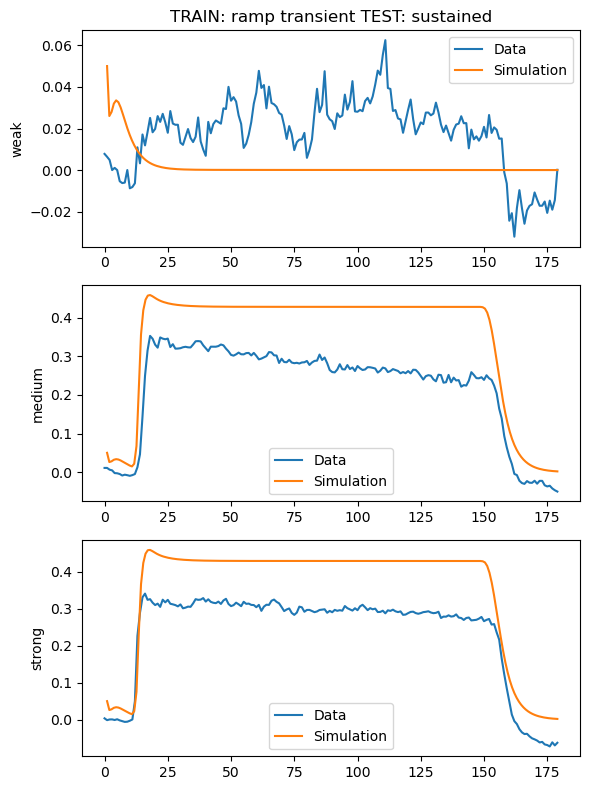

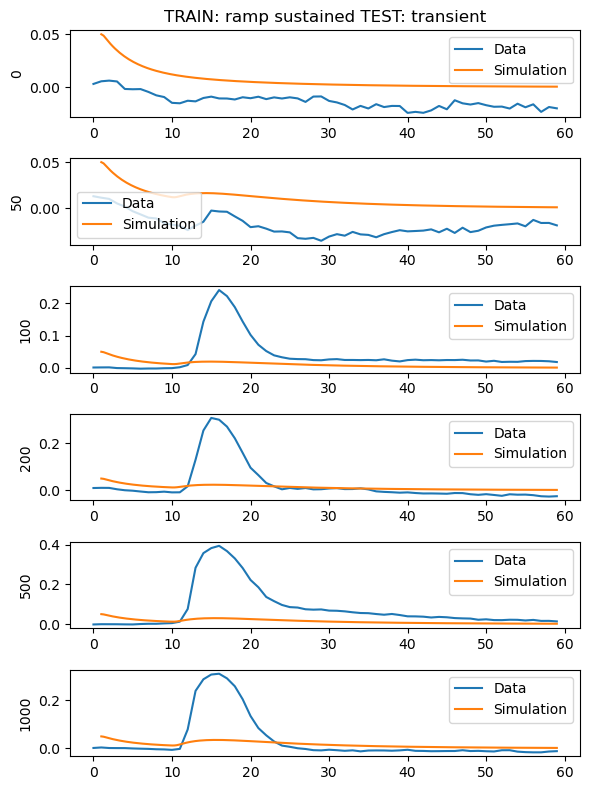

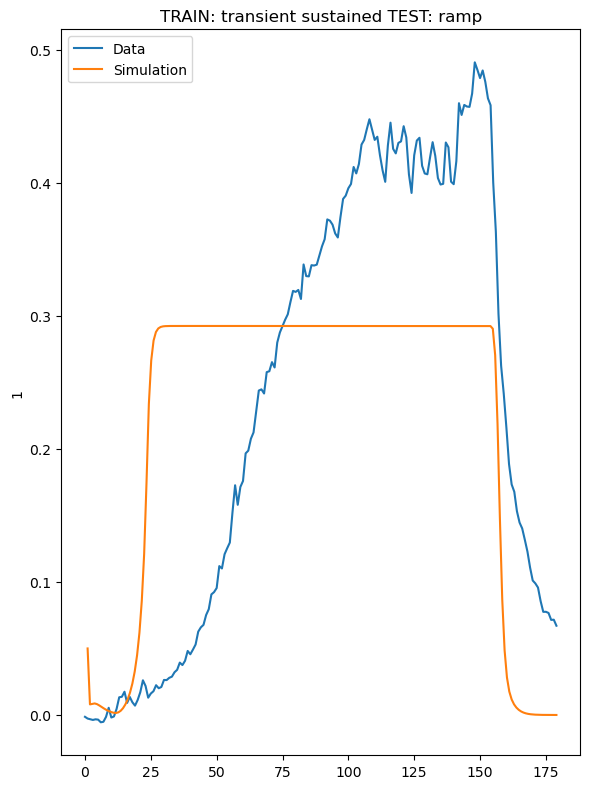

In [ ]:
# 
#figs = []
#y0 = [0.05] * 5
#sim_steps = 200
#for res in results_single.values():
#  groups = res['groups']
#  fs = (6,8) if 'transient' in res['name'] else (6,6)
#  fig, ax = plt.subplots(len(groups), squeeze=False, figsize=fs, tight_layout=True)
#  fig.suptitle(f"{res['name']}")
#  #ax[0,0].set_title("Data")
#  #ax[0,1].set_title("Simulation")
#  df = res['df']
#  t_max = max(df['time'])
#  y_max = max(df['y']) * 1.1
#
#  for gr_i, gr in enumerate(groups):
#    dff = df[df['group'] == gr]
#    sim_t =res['results_by_group'][gr][2]
# 
#    ax[gr_i,0].plot(dff['time'], dff['y'],label=f'Data')
#    ax[gr_i,0].set_ylim(0,y_max)
#    ax[gr_i,0].set_ylabel(gr)
#    #sol = m.simulate(sim_t, y0, group=gr)
#    sol = res['results_by_group'][gr][1]
#    ax[gr_i,0].plot(sim_t, sol.y[-1], label='Simulation')
#    #ax[gr_i,0].set_ylim(0,y_max)
#    ax[gr_i,0].legend()
#  figs.append(fig)
figs = []
for fold_name, fold in results_multi.items():
  test_groups = list(fold['results_by_group'].keys())
  fig, ax = plt.subplots(len(test_groups), squeeze=False,tight_layout=False, figsize= (6,8))
  fname = fold_name.replace('cross_val_', '').replace('models.', ' ').replace('___', ' ')
  ax[0,0].set_title(fname)
  
  #ax[0,0].set_title(fold_name)
  for i, t_gr in enumerate(test_groups):
    dff, sol, sim_t, dff = fold['results_by_group'][t_gr] 
    #y_max = max(dff['y']) * 1.1
 
    ax[i,0].plot(dff['time'], dff['y'],label=f'Data')
    #ax[i,0].set_ylim(0,y_max)
    ax[i,0].set_ylabel(t_gr)
    ax[i,0].plot(sim_t, sol.y[-1], label='Simulation')
    ax[i,0].legend()
    ax[i,0].set_ylim((0,0.45))
  figs.append(fig)

len(figs)


  
  

In [ ]:

#idx = 1
#names = [f'cv_fit_{m}' for m in reversed(['ramp', 'transient','sustained'])]
#pts = f'/Users/polya/workshop/research_project_report/static/'
#for f,n in zip(figs,names):
#  f.savefig(f'{pts}{n}_{idx}.png')